# Resource Usage Plots
### Compare Runtime and Memory Usage for tasks in up to three collections.


In [1]:
from lsst.daf.butler import Butler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.lines import Line2D

In [2]:
REPO1 = "/repo/embargo"
COLLECTION1 = "LSSTComCamSim/runs/nightlyvalidation/20240402/d_2024_03_29/DM-43612"

REPO2 = "s3://embargo@repo-test-users/repotest02"
COLLECTION2 = "u/yusra/nv_test1/20240402/w_2024_24/DM-44831"

REPO3 = None
COLLECTION3 = None

repos = [REPO1, REPO2, REPO3]
collections = [COLLECTION1, COLLECTION2, COLLECTION3]

In [3]:
dfs = []

for repo, collection in zip(repos, collections):
    if repo and collection:
        butler = Butler(repo, collections=[collection])
        df = butler.get("ResourceUsageSummary")
        df['collection'] = collection
        dfs.append(df)
        
both = pd.concat(dfs)

In [4]:
def custom_boxplot(data, y, hue, value_prefix, xlabel, sortby, logscale=False):
    versions = sorted(data[hue].drop_duplicates())
    tasks = data.groupby("task").sum()[sortby].sort_values(ascending=True).index
    
    palette = sns.color_palette(n_colors=len(versions))

    fig, ax = plt.subplots(figsize=(8, 8))

    for i, task in enumerate(tasks):
        for j, version in enumerate(versions):
            sub_group = data[(data[y] == task) & (data[hue] == version)]
            if not sub_group.empty:
                min_rt = sub_group[f'{value_prefix}p000'].values[0]
                q1 = sub_group[f'{value_prefix}p032'].values[0]
                median = sub_group[f'{value_prefix}p050'].values[0]
                q3 = sub_group[f'{value_prefix}p068'].values[0]
                max_rt = sub_group[f'{value_prefix}p100'].values[0]

                # Calculate the position for the box with offset for each version
                position = i + (j * 0.25) - (0.5 * (len(versions) - 1)) + 0.4

                ax.plot([min_rt, q1], [position, position], color=palette[j], linestyle='-', lw=1.5)
                ax.plot([q1, q3], [position, position], color=palette[j], lw=6, solid_capstyle='butt')
                ax.plot([q3, max_rt], [position, position], color=palette[j], linestyle='-', lw=1.5)
                ax.plot([median], [position], marker='|', color='k')
    ax.set_yticks(range(len(tasks)))
    ax.set_yticklabels(tasks)

    handles = [Line2D([0], [0], color=palette[i], lw=4) for i in range(len(versions))]
    ax.legend(handles, versions, title=hue, loc='lower left', bbox_to_anchor=(0, 1.02), borderaxespad=0, ncol=1)
    
    ax.set_xlabel(xlabel)
    if logscale:
        ax.set_xscale('log')
    plt.show()

## Runtime for top 20 longest Tasks, sorted by integrated runtime. 

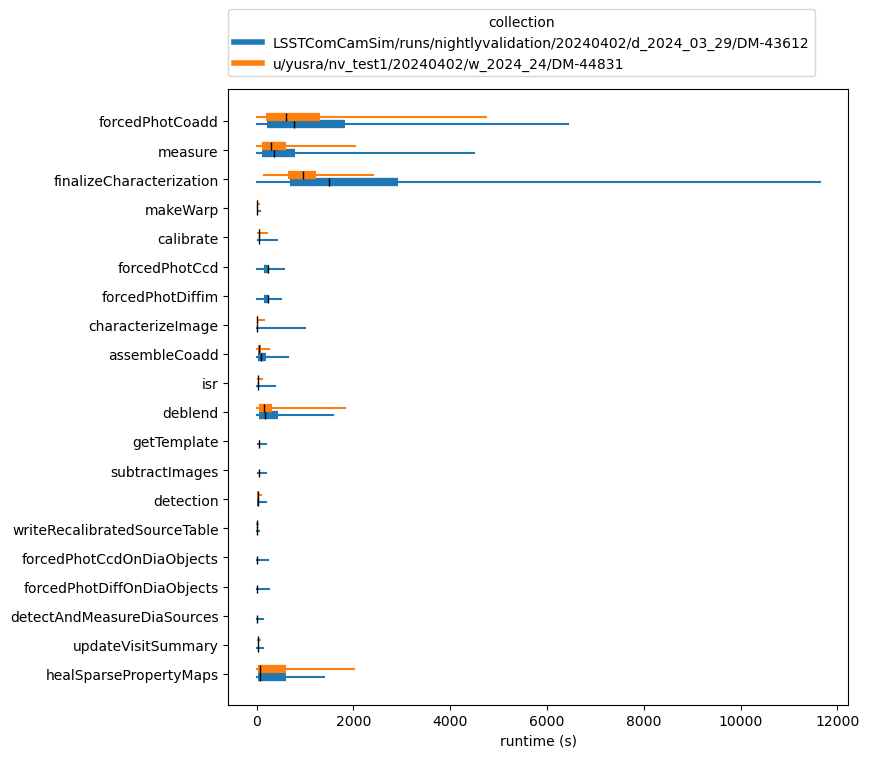

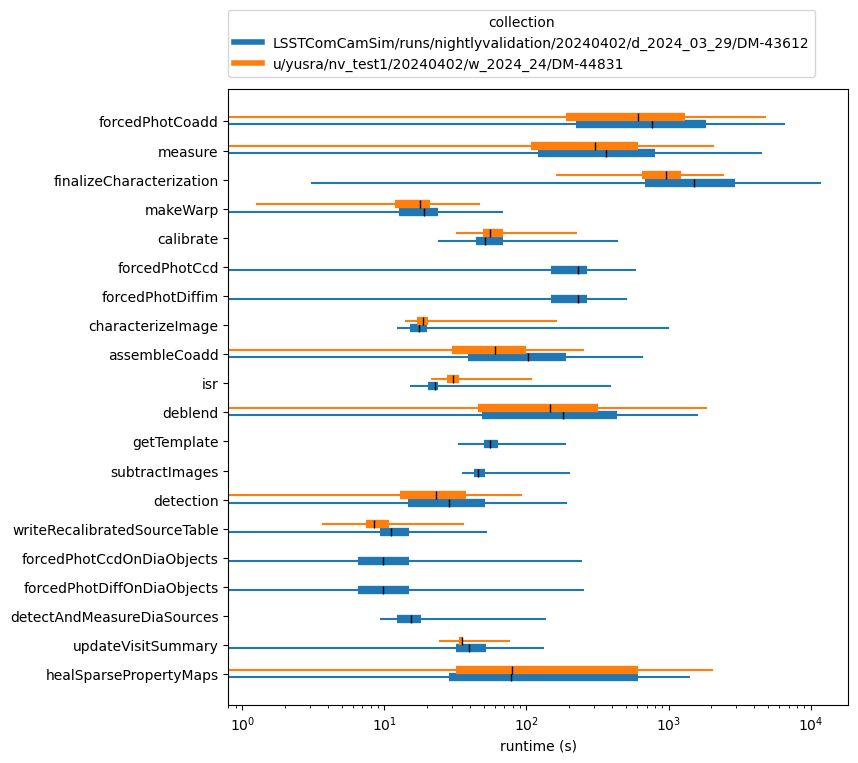

In [5]:
tasks = both.groupby("task").sum()["integrated_runtime_hrs"].sort_values(ascending=False).head(20).index
pivoted_df = both[(both.task.isin(tasks))].sort_values('integrated_runtime_hrs', ascending=True) 
custom_boxplot(pivoted_df, y='task', hue='collection', value_prefix="runtime_s_", xlabel="runtime (s)", sortby="integrated_runtime_hrs", logscale=False)
custom_boxplot(pivoted_df, y='task', hue='collection', value_prefix="runtime_s_", xlabel="runtime (s)", sortby="integrated_runtime_hrs", logscale=True)

## Tasks with memory usage over 2GB, sorted by max memory usage.

If the processing was run with clustering, the memory usage is reported per cluster not per task. Use caution when interpreting. 

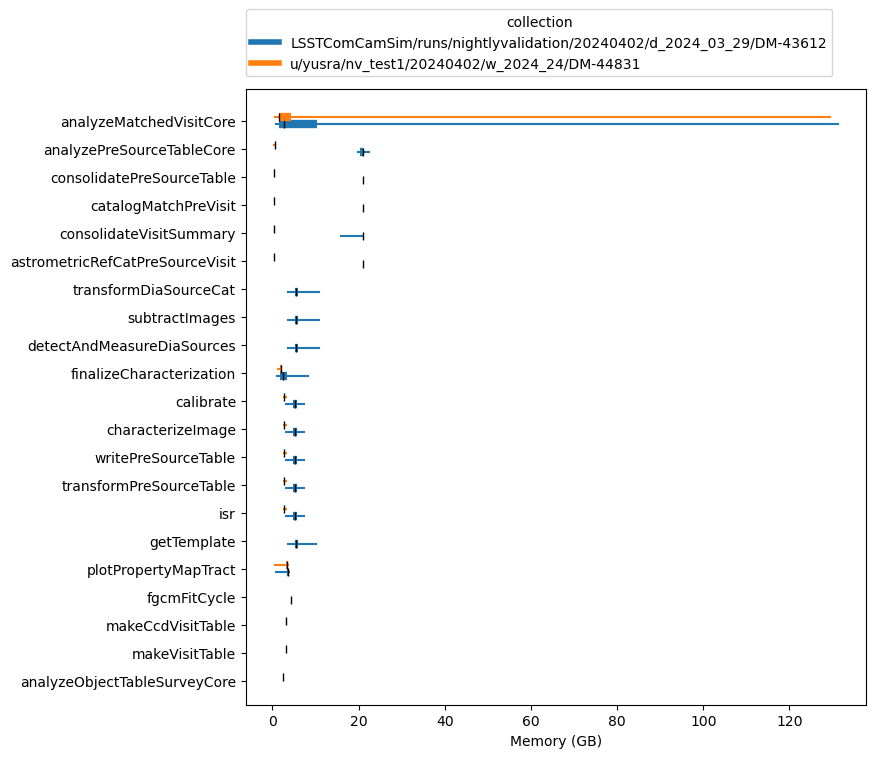

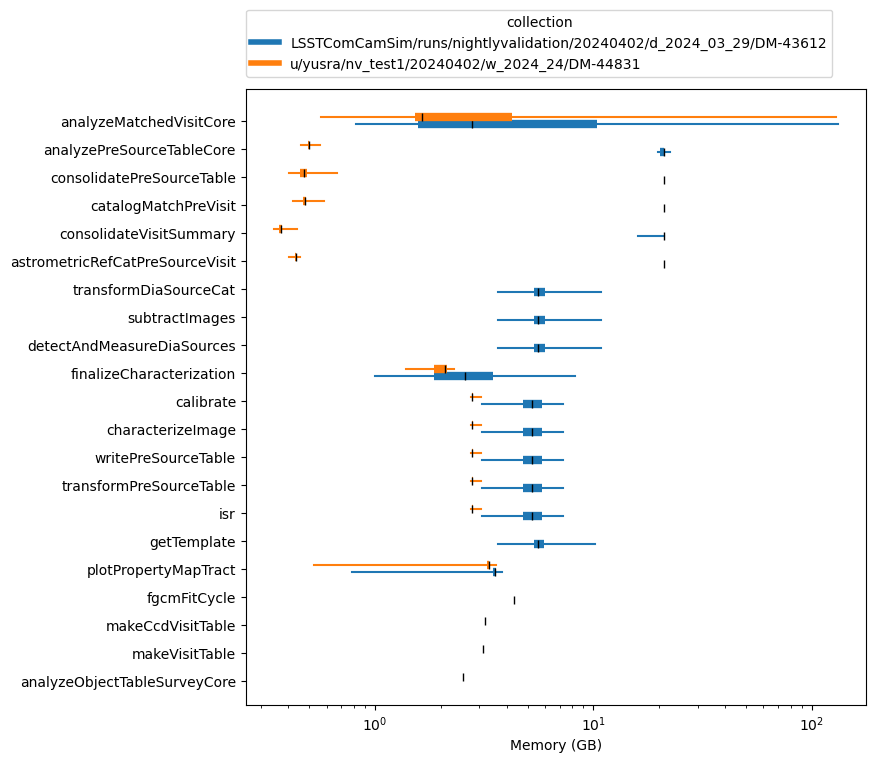

In [6]:
pivoted_df = both[(both.task.isin(both[(both.mem_GB_p050 > 2)]["task"].unique()))].sort_values('mem_GB_p100', ascending=True)  #  pd.DataFrame(data)
custom_boxplot(pivoted_df, y='task', hue='collection', value_prefix="mem_GB_", xlabel="Memory (GB)", sortby='mem_GB_p100', logscale=False)
custom_boxplot(pivoted_df, y='task', hue='collection', value_prefix="mem_GB_", xlabel="Memory (GB)", sortby='mem_GB_p100', logscale=True)

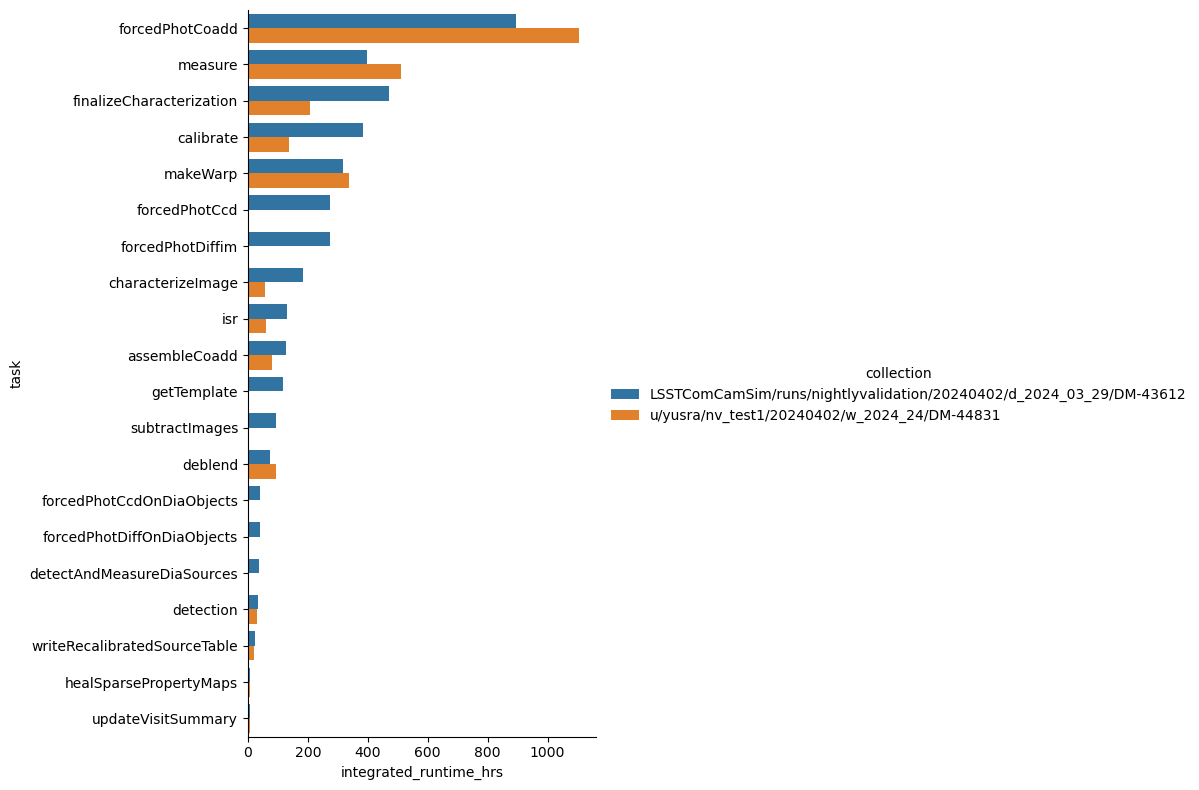

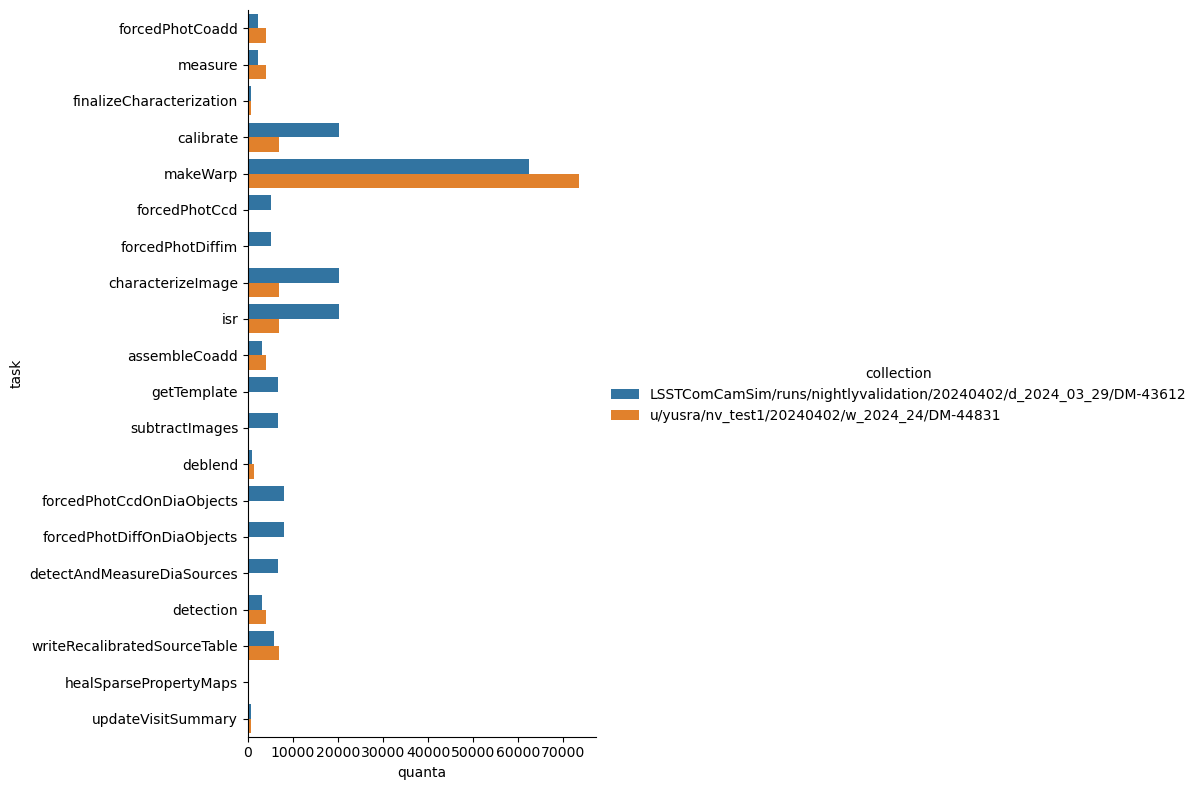

In [7]:
# Get top 20 tasks with longest integrated runtime:
tasks = both.groupby("task").sum()["integrated_runtime_hrs"].sort_values(ascending=False).head(20).index
df = both[both.task.isin(tasks)].sort_values('integrated_runtime_hrs', ascending=False)
hue_order = sorted(df["collection"].drop_duplicates())

ax = sns.catplot(data=df, y="task", x="integrated_runtime_hrs", hue="collection", height=8, hue_order=hue_order, kind="bar")
ax = sns.catplot(data=df, y="task", x="quanta", hue="collection", height=8, hue_order=hue_order, kind="bar")